<a href="https://colab.research.google.com/github/nickwinters1/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

In [11]:
!pip install category-encoders
!pip install eli5
!pip install shap

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 102kB 2.7MB/s 
     |████████████████████████████████| 225kB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap


In [29]:
train.columns

Index(['Inspection ID', 'Risk', 'Zip', 'Inspection Date', 'Violations',
       'Latitude', 'Longitude', 'Fail', 'Facility_1.0', 'Facility_2.0',
       'Facility_3.0', 'Inspection_canvass', 'Inspection_complaint',
       'Inspection_other', 'Inspection_poison', 'Inspection_re-inspection',
       'Inspection Month', 'Inspection Year'],
      dtype='object')

In [30]:
train.isnull().sum()

Inspection ID               0
Risk                        0
Zip                         0
Inspection Date             0
Violations                  0
Latitude                    0
Longitude                   0
Fail                        0
Facility_1.0                0
Facility_2.0                0
Facility_3.0                0
Inspection_canvass          0
Inspection_complaint        0
Inspection_other            0
Inspection_poison           0
Inspection_re-inspection    0
Inspection Month            0
Inspection Year             0
dtype: int64

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

def wrangle(df): 
  df = df.copy()
  
  #Dropping columns that are not needed
  df = df.drop(columns = ['DBA Name', 'AKA Name', 'License #', 'Address', 'Location', 'City', 'State'])
  
  def clean_facility(string):
    foods_drinks = ['Restaurant', 'Grocery Store', 'Bakery', 'Catering',
                   'Liquor', 'Golden Diner', 'Mobile Food Preparer',
                   'Mobile Food Dispenser', 'Tavern', 'TAVERN']
    kids_stuff = ['School', 'Daycare (2 - 6 Years)', "Children's Services Facility",
                 'Daycare Above and Under 2 Years', 'Long Term Care', 'Daycare Combo 1586', 'Daycare (Under 2 Years)']
    if type(string) is str:
      if string in foods_drinks:
        return 3
      elif string in kids_stuff:
        return 2
      else:
        return 1
  
  
  df['Facility Type'] = df['Facility Type'].apply(clean_facility)
  
  def clean_violation(entry):
    if(type(entry) == str):
      return entry.split('.')[0]
    else:
      return entry
  df.Violations = df.Violations.apply(clean_violation)
  df.Violations.fillna(0)
  
  #let's rename categories so people can understand:
  risk_dict = {'Risk 1 (High)': 1, 'Risk 2 (Medium)': 2, 'Risk 3 (Low)': 3}
  df.Risk = df.Risk.replace(risk_dict)
  
  
  #Now we need to remove missing/NA values
  df = df.dropna()
  
  #Finally Clean Inspection
  
  def clean_inspection(string):
    words = string.lower().split()
    if 'complaint' in words:
      return 'complaint'
    elif 'canvass' in words:
      return 'canvass'
    elif 're-inspection' in words:
      return 're-inspection'
    elif 'poisoning' in words:
      return 'poison'
    else:
      return 'other'
      
  df['Inspection Type'] = df['Inspection Type'].apply(clean_inspection)
  
  enc = ce.OrdinalEncoder()
  
  one_hot = pd.get_dummies(df['Facility Type'], prefix = 'Facility')
  df = df.join(one_hot)
  df = df.drop(columns = ['Facility Type'])
  
  one_hot = pd.get_dummies(df['Inspection Type'], prefix = 'Inspection')
  df = df.join(one_hot)
  df = df.drop(columns = ['Inspection Type'])
  
  df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])
  df['Inspection Month'] = df['Inspection Date'].apply(lambda x: x.month)
  df['Inspection Year'] = df['Inspection Date'].apply(lambda x: x.year)
  df.Violations = df.Violations.apply(int)
  return df

train = wrangle(train)
test = wrangle(test)

I found that violations is leaky.


### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._

In [32]:
train.columns

Index(['Inspection ID', 'Risk', 'Zip', 'Inspection Date', 'Violations',
       'Latitude', 'Longitude', 'Fail', 'Facility_1.0', 'Facility_2.0',
       'Facility_3.0', 'Inspection_canvass', 'Inspection_complaint',
       'Inspection_other', 'Inspection_poison', 'Inspection_re-inspection',
       'Inspection Month', 'Inspection Year'],
      dtype='object')

In [0]:
features = ['Risk', 'Zip', 'Inspection_canvass', 'Inspection_complaint',
       'Inspection_other', 'Inspection_poison', 'Inspection_re-inspection',
            'Inspection Month',
            'Inspection Year', 'Latitude', 'Longitude']

X_train = train[features].dropna()
y_train = train['Fail'].dropna()

X_test = test[features].dropna()
y_test = test['Fail'].dropna()

In [35]:
X_train.isnull().sum()

Risk                        0
Zip                         0
Inspection_canvass          0
Inspection_complaint        0
Inspection_other            0
Inspection_poison           0
Inspection_re-inspection    0
Inspection Month            0
Inspection Year             0
Latitude                    0
Longitude                   0
dtype: int64

In [47]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

param_distributions = {
    'n_estimators': randint(100,500), 
    'max_depth': randint(2,4)
}

gridsearch = RandomizedSearchCV(
    XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=4, 
    cv=3, 
    scoring='roc_auc', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

gridsearch.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score

print(gridsearch.best_score_)

best = gridsearch.best_estimator_

y_pred = best.predict_proba(X_test)[:,1]

print(roc_auc_score(y_test, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   46.1s finished


0.6653957431422305
0.6743299634441269


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

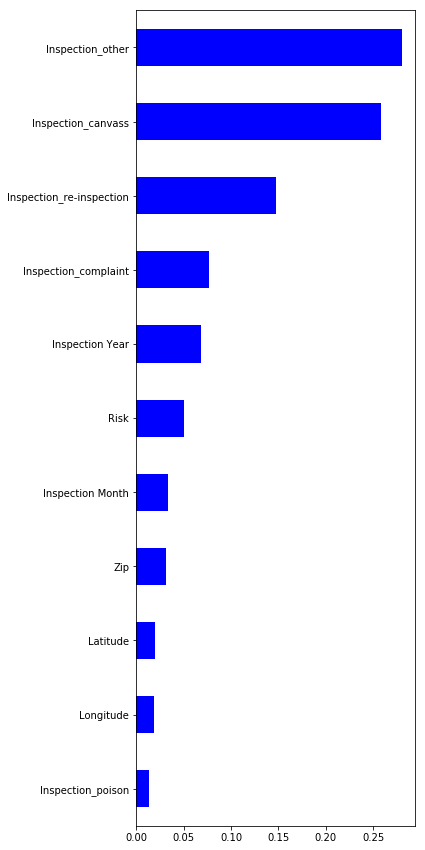

In [37]:
#Feature Plot

import matplotlib.pyplot as plt

n = 15
figsize = (5,15)
importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize=figsize)
top_n.plot.barh(color='blue')

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

1. Gradient Descent searches to minimize the function by using algorithms, it locates the direction of the decent along the negative gradient.

2. The learning rate shows you how much you need to scale the gradient when going through the gradient descent algorithm.